# Visualization of the grid of chords

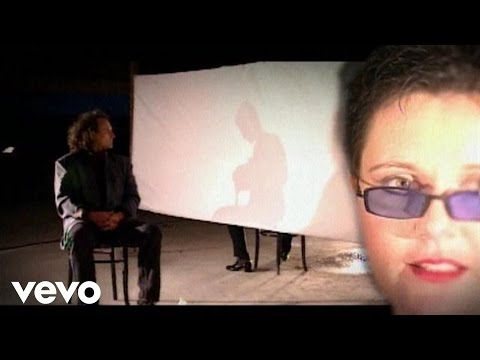

In [624]:
from IPython.display import YouTubeVideo
YouTubeVideo("P1gGTMYBvgk")

In [625]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

mpl.rc('image', interpolation='nearest', cmap='Set2')
mpld3.enable_notebook()

## As a timeline grid

In [626]:
all_half_beats = pd.read_csv('hladova-zed-half-beats.txt', header=None)[0]

In [627]:
le = LabelEncoder()
all_half_beats_numeric = le.fit_transform(all_half_beats)
all_half_beats_numeric

array([1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 6, 6, 1, 8, 2, 8, 1, 8, 2,
       8, 1, 8, 2, 8, 1, 8, 6, 6, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8,
       6, 6, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 6, 6, 0, 0, 0, 0, 3,
       3, 3, 3, 0, 0, 0, 0, 7, 7, 6, 6, 2, 2, 8, 8, 1, 1, 1, 1, 5, 5, 8, 1,
       2, 2, 2, 2, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 6, 6, 0, 0, 0,
       0, 3, 3, 3, 3, 0, 0, 0, 4, 7, 7, 6, 6, 2, 2, 8, 8, 1, 1, 1, 1, 5, 5,
       8, 1, 2, 2, 2, 2, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1,
       8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 6, 6, 0, 0, 0, 0, 3, 3, 3, 3,
       0, 0, 0, 4, 7, 7, 6, 6, 2, 2, 8, 8, 1, 1, 1, 1, 5, 5, 8, 1, 2, 2, 2,
       2, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8,
       2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1,
       8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8, 1, 8, 2, 8,
       1, 8, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2])

In [628]:
print('number of unique chords:', len(le.classes_))
print(le.classes_)

number of unique chords: 9
['Am6' 'Am7' 'Em' 'Em9' 'F#7' 'H4/C' 'H7' 'H7/4' 'Hm7']


In [629]:
section_lengths = [2,2,2,2,4,2,4,2,2,4,7,2,1]
assert sum(section_lengths)*8 == len(all_half_beats)

section_classes = [
    'instrumental',
    'guitar_intro',
    'verse_A',
    'verse_A',
    'chorus_A',
    'verse_A',
    'chorus_B',
    'verse_B',
    'guitar_solo',
    'chorus_B',
    'verse_C',
    'instrumental',
    'ending'
]
assert len(section_classes) == len(section_lengths)

In [630]:
section_starts = np.cumsum([0]+section_lengths)[:-1]

In [631]:
le_sections = LabelEncoder().fit(section_classes)
le_sections_numeric = le_sections.transform(section_classes)

In [632]:
row_size = 8
row_count = len(all_half_beats_numeric) // row_size

In [633]:
df = pd.DataFrame({'section': le_sections_numeric}, index=section_starts)
df = df.reindex(np.arange(row_count))
df.fillna(method='ffill', inplace=True)
df['section'] = df['section'].astype(int)
df['section_name'] = df['section'].apply(le_sections.inverse_transform)
df
section_per_row = df['section']

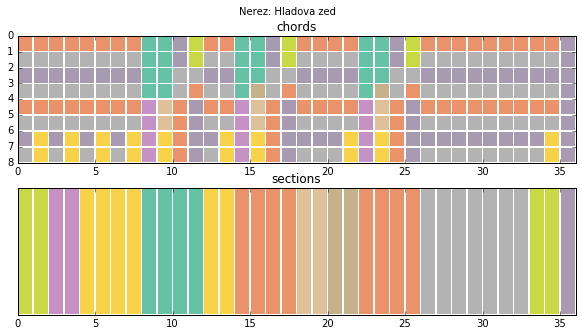

In [634]:
# time: first columns top to bottom, then rows left to right
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 5))

fig.suptitle('Nerez: Hladova zed')

ax1.set_xlim(0, row_count)
ax2.set_xlim(0, row_count)
values = all_half_beats_numeric.reshape(-1, 8).T
mesh = ax1.pcolormesh(values, edgecolors='w', linewidth=0.5)
ax1.set_title('chords')
ax1.invert_yaxis()

css = """
.mpld3-tooltip {
    background: white;
    padding: 5px;
    border: 1px solid #aaa;
    border-radius: 2px;
}
"""
labels = [le.inverse_transform(i) for i in values.flatten()]
tooltip = mpld3.plugins.PointHTMLTooltip(mesh, labels, hoffset=10, voffset=10, css=css)
mpld3.plugins.connect(fig, tooltip)


mesh2 = ax2.pcolormesh(section_per_row.reshape(1, -1), edgecolors='w', linewidth=0.5)
tooltip = mpld3.plugins.PointHTMLTooltip(
    mesh2,
    labels=[le_sections.inverse_transform(i) for i in section_per_row],
    hoffset=10, voffset=10, css=css)
mpld3.plugins.connect(fig, tooltip)
ax2.set_title('sections')
ax2.set_yticks([])

plt.savefig('hladova-zed-grid.pdf')

## n-grams

2-grams aligned to even indexes (ie. (0, 1) can be extracted, but (1,2) can not).

4-grams aligned to indexes modulo 4, etc.

In [635]:
def aligned_ngrams(values, n):
    return [tuple(values[i]) for i in np.arange(len(values)).reshape(-1, n)]

def aligned_ngram_set(values, n):
    return set(aligned_ngrams(values, n))

In [636]:
ngrams_1 = aligned_ngram_set(all_half_beats, 1)
ngrams_1

{('Am6',),
 ('Am7',),
 ('Em',),
 ('Em9',),
 ('F#7',),
 ('H4/C',),
 ('H7',),
 ('H7/4',),
 ('Hm7',)}

In [637]:
ngrams_2 = aligned_ngram_set(all_half_beats, 2)
ngrams_2

{('Am6', 'Am6'),
 ('Am6', 'F#7'),
 ('Am7', 'Am7'),
 ('Am7', 'Hm7'),
 ('Em', 'Em'),
 ('Em', 'Hm7'),
 ('Em9', 'Em9'),
 ('H4/C', 'H4/C'),
 ('H7', 'H7'),
 ('H7/4', 'H7/4'),
 ('Hm7', 'Am7'),
 ('Hm7', 'Hm7')}

In [638]:
ngrams_4 = aligned_ngram_set(all_half_beats, 4)
ngrams_4

{('Am6', 'Am6', 'Am6', 'Am6'),
 ('Am6', 'Am6', 'Am6', 'F#7'),
 ('Am7', 'Am7', 'Am7', 'Am7'),
 ('Am7', 'Hm7', 'Em', 'Hm7'),
 ('Am7', 'Hm7', 'H7', 'H7'),
 ('Em', 'Em', 'Em', 'Em'),
 ('Em', 'Em', 'Hm7', 'Hm7'),
 ('Em9', 'Em9', 'Em9', 'Em9'),
 ('H4/C', 'H4/C', 'Hm7', 'Am7'),
 ('H7/4', 'H7/4', 'H7', 'H7')}

In [639]:
ngrams_8 = aligned_ngram_set(all_half_beats, 8)
ngrams_8

{('Am6', 'Am6', 'Am6', 'Am6', 'Em9', 'Em9', 'Em9', 'Em9'),
 ('Am6', 'Am6', 'Am6', 'Am6', 'H7/4', 'H7/4', 'H7', 'H7'),
 ('Am6', 'Am6', 'Am6', 'F#7', 'H7/4', 'H7/4', 'H7', 'H7'),
 ('Am7', 'Hm7', 'Em', 'Hm7', 'Am7', 'Hm7', 'Em', 'Hm7'),
 ('Am7', 'Hm7', 'Em', 'Hm7', 'Am7', 'Hm7', 'H7', 'H7'),
 ('Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em'),
 ('Em', 'Em', 'Hm7', 'Hm7', 'Am7', 'Am7', 'Am7', 'Am7'),
 ('H4/C', 'H4/C', 'Hm7', 'Am7', 'Em', 'Em', 'Em', 'Em')}

In [640]:
for ngrams in ngrams_1, ngrams_2, ngrams_4, ngrams_8:
    print(len(ngrams))

9
12
10
8


## As a graph

In [641]:
from graphviz import Digraph
import colorsys

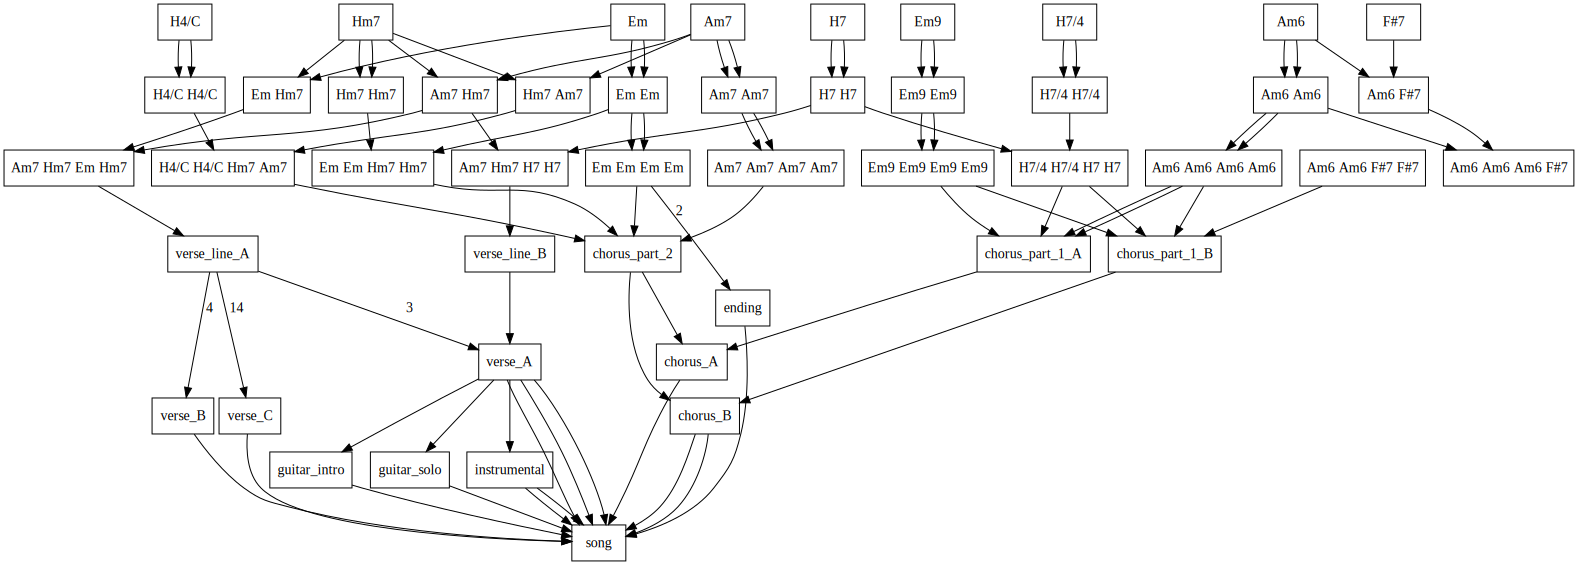

In [642]:
dot = Digraph(graph_attr={'overlap': 'false'})
dot.attr('node', shape='box')
for n in ngrams_1:
    dot.node(n[0])

def draw_ngram_layer(ngrams, n):
    for t in ngrams:
        node = ' '.join(t)
        dot.node(node)
        stride = n//2
        sources = [' '.join((t[stride*i:stride*(i+1)])) for i in range(2)]
        for src in sources:
            dot.edge(src, node)

draw_ngram_layer(ngrams_2, 2)
draw_ngram_layer(ngrams_4, 4)

dot.node('verse_line_A')
dot.edge('Am7 Hm7 Em Hm7', 'verse_line_A')
dot.edge('Am7 Hm7 H7 H7', 'verse_line_B')

dot.node('verse_A')
dot.edge('verse_line_A', 'verse_A', '3')
dot.edge('verse_line_B', 'verse_A')

dot.node('verse_B')
dot.edge('verse_line_A', 'verse_B', '4')

dot.node('guitar_intro')
dot.edge('verse_A', 'guitar_intro')

dot.node('guitar_solo')
dot.edge('verse_A', 'guitar_solo')

dot.node('instrumental')
dot.edge('verse_A', 'instrumental')

dot.node('chorus_part_1_A')
dot.edge(' '.join(4*['Am6']), 'chorus_part_1_A')
dot.edge(' '.join(4*['Em9']), 'chorus_part_1_A')
dot.edge(' '.join(4*['Am6']), 'chorus_part_1_A')
dot.edge(' '.join(2*['H7/4'] + 2*['H7']), 'chorus_part_1_A')

dot.node('chorus_part_1_B')
dot.edge(' '.join(4*['Am6']), 'chorus_part_1_B')
dot.edge(' '.join(4*['Em9']), 'chorus_part_1_B')
dot.edge(' '.join(2*['Am6'] + 2*['F#7']), 'chorus_part_1_B')
dot.edge(' '.join(2*['H7/4'] + 2*['H7']), 'chorus_part_1_B')

dot.node('chorus_part_2')
dot.edge(' '.join(2*['Em'] + 2*['Hm7']), 'chorus_part_2')
dot.edge(' '.join(4*['Am7']), 'chorus_part_2')
dot.edge(' '.join(2*['H4/C'] + ['Hm7', 'Am7']), 'chorus_part_2')
dot.edge(' '.join(4*['Em']), 'chorus_part_2')

dot.node('chorus_A')
dot.edge('chorus_part_1_A', 'chorus_A')
dot.edge('chorus_part_2', 'chorus_A')

dot.node('chorus_B')
dot.edge('chorus_part_1_B', 'chorus_B')
dot.edge('chorus_part_2', 'chorus_B')

dot.node('verse_C')
dot.edge('verse_line_A', 'verse_C', '14')

dot.node('ending')
dot.edge(' '.join(4*['Em']), 'ending', '2')

dot.node('song')
dot.edge('instrumental', 'song')
dot.edge('guitar_intro', 'song')
dot.edge('verse_A', 'song')
dot.edge('verse_A', 'song')
dot.edge('chorus_A', 'song')
dot.edge('verse_A', 'song')
dot.edge('chorus_B', 'song')
dot.edge('verse_B', 'song')
dot.edge('guitar_solo', 'song')
dot.edge('chorus_B', 'song')
dot.edge('verse_C', 'song')
dot.edge('instrumental', 'song')
dot.edge('ending', 'song')
    
dot.render('hladova-zed-graph.gv')
dot

## Sequence of 8-grams

Let's treat sections as sequences of unique 8-grams.

In [643]:
le_8ngram = LabelEncoder().fit([' '.join(n) for n in ngrams_8])

In [644]:
all_ngrams_8 = [' '.join(n) for n in aligned_ngrams(all_half_beats, 8)]
all_ngrams_8

['Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7',
 'Am6 Am6 Am6 Am6 Em9 Em9 Em9 Em9',
 'Am6 Am6 Am6 Am6 H7/4 H7/4 H7 H7',
 'Em Em Hm7 Hm7 Am7 Am7 Am7 Am7',
 'H4/C H4/C Hm7 Am7 Em Em Em Em',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7',
 'Am6 Am6 Am6 Am6 Em9 Em9 Em9 Em9',
 'Am6 Am6 Am6 F#7 H7/4 H7/4 H7 H7',
 'Em Em Hm7 Hm7 Am7 Am7 Am7 Am7',
 'H4/C H4/C Hm7 Am7 Em Em Em Em',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7',
 'Am6 Am6 Am6 Am6 Em9 Em9 Em9 Em9',
 'Am6 Am6 Am6 F#7 H7/4 H7/4 H7 H7',
 'Em Em Hm7 Hm7 Am7 Am7 Am7 Am7',
 'H4/C H4/C Hm7 Am7 Em Em Em Em',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7',
 'Am7 Hm

In [645]:
all_ngrams_8_numeric = le_8ngram.transform(all_ngrams_8)

### Plot of sequence unique 8-grams

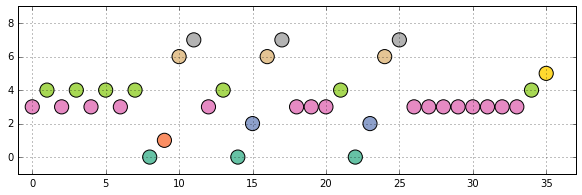

In [660]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
ax.grid(True)
scatter = ax.scatter(np.arange(len(all_ngrams_8_numeric)), all_ngrams_8_numeric, c=all_ngrams_8_numeric, s=200)
ax.set_xlim(-1, len(all_ngrams_8_numeric)+1)
ax.set_ylim(-1, len(set(all_ngrams_8_numeric))+1)

mpld3.plugins.connect(fig, mpld3.plugins.PointHTMLTooltip(
        scatter, labels=['[%d] %s' % (le_8ngram.transform(i), i) for i in all_ngrams_8],
        hoffset=10, voffset=10, css=css));

plt.savefig('hladova-zed-sequence-8-gram.pdf')

In [648]:
len(all_ngrams_8_numeric)

36

In [649]:
df['ngram_8'] = all_ngrams_8_numeric
df['ngram_8_name'] = all_ngrams_8

In [650]:
df

,section,section_name,ngram_8,ngram_8_name
0,5,instrumental,3,Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7
1,5,instrumental,4,Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7
2,3,guitar_intro,3,Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7
3,3,guitar_intro,4,Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7
4,6,verse_A,3,Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7
5,6,verse_A,4,Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7
6,6,verse_A,3,Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7
7,6,verse_A,4,Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7
8,0,chorus_A,0,Am6 Am6 Am6 Am6 Em9 Em9 Em9 Em9
9,0,chorus_A,1,Am6 Am6 Am6 Am6 H7/4 H7/4 H7 H7


In [651]:
[
    ('guitar_intro', [3,4]),
    ('guitar_solo', [3,4]),
    ('instrumental', [3,4]),
    ('verse_A', [3,4]),
    ('verse_B', [3,3]),
    ('verse_C', [3,3,3,3,3,3,3]),
    ('chorus_A', [0,1,6,7]),
    ('chorus_B', [0,2,6,7]),
    ('ending', [2])
]

[('guitar_intro', [3, 4]),
 ('guitar_solo', [3, 4]),
 ('instrumental', [3, 4]),
 ('verse_A', [3, 4]),
 ('verse_B', [3, 3]),
 ('verse_C', [3, 3, 3, 3, 3, 3, 3]),
 ('chorus_A', [0, 1, 6, 7]),
 ('chorus_B', [0, 2, 6, 7]),
 ('ending', [2])]

## State machine representation

### Transitions between chords

In [652]:
ngrams_1

{('Am6',),
 ('Am7',),
 ('Em',),
 ('Em9',),
 ('F#7',),
 ('H4/C',),
 ('H7',),
 ('H7/4',),
 ('Hm7',)}

In [653]:
def ngrams(values, n):
    return sorted(set(zip(values[:-1], values[1:])))

ngrams_2_unaligned = ngrams(all_half_beats, 2)
print(len(ngrams_2_unaligned))
ngrams_2_unaligned

26


[('Am6', 'Am6'),
 ('Am6', 'Em9'),
 ('Am6', 'F#7'),
 ('Am6', 'H7/4'),
 ('Am7', 'Am7'),
 ('Am7', 'Em'),
 ('Am7', 'H4/C'),
 ('Am7', 'Hm7'),
 ('Em', 'Am7'),
 ('Em', 'Em'),
 ('Em', 'Hm7'),
 ('Em9', 'Am6'),
 ('Em9', 'Em9'),
 ('F#7', 'H7/4'),
 ('H4/C', 'H4/C'),
 ('H4/C', 'Hm7'),
 ('H7', 'Am6'),
 ('H7', 'Am7'),
 ('H7', 'Em'),
 ('H7', 'H7'),
 ('H7/4', 'H7'),
 ('H7/4', 'H7/4'),
 ('Hm7', 'Am7'),
 ('Hm7', 'Em'),
 ('Hm7', 'H7'),
 ('Hm7', 'Hm7')]

In [654]:
def desc_by_src(ngrams_2):
    return pd.DataFrame(ngrams_2, columns=['src', 'desc']).groupby('src')['desc'].apply(list)

desc_by_src(ngrams_2_unaligned)

src
Am6     [Am6, Em9, F#7, H7/4]
Am7      [Am7, Em, H4/C, Hm7]
Em             [Am7, Em, Hm7]
Em9                [Am6, Em9]
F#7                    [H7/4]
H4/C              [H4/C, Hm7]
H7         [Am6, Am7, Em, H7]
H7/4               [H7, H7/4]
Hm7        [Am7, Em, H7, Hm7]
Name: desc, dtype: object

In [655]:
def colorize(values):
    norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
    m = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.get_cmap()) 
    return [m.to_rgba(x)[:3] for x in values]

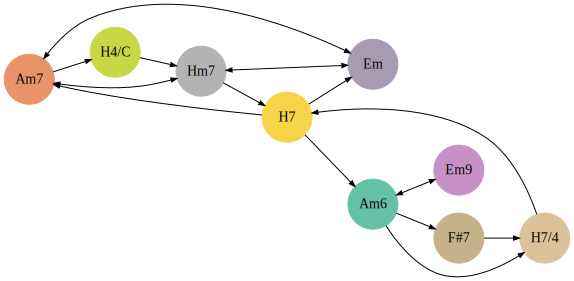

In [694]:
dot_ngrams_2 = Digraph(
    graph_attr={'rankdir': 'LR', 'concentrate': 'true'},
    node_attr={'width': '0.7', 'height': '0.7', 'shape': 'circle', 'fixedsize': 'true'},
    edge_attr={'arrowsize': '0.6'}
)
ngrams_2_unaligned_desc_by_src = desc_by_src(ngrams_2_unaligned)
# 8-gram ids in the original order of appearance
keys = list(pd.Series(all_half_beats).drop_duplicates())
colors = colorize(le.transform(keys))
for src, color_rgb in zip(keys, colors):
    dot_ngrams_2.node(src, color='%f, %f, %f' % colorsys.rgb_to_hsv(*color_rgb), style='filled')
for src, dests in ngrams_2_unaligned_desc_by_src.iteritems():
    for dest in dests:
        if src != dest:
            dot_ngrams_2.edge(src, dest)

dot_ngrams_2.render('hladova-zed-chord-state-diagram.gv')
dot_ngrams_2

Total number of states (nodes) and state transitions (edges) is relatively small. So this might be quite easy to comprehend.

On the other hand, we need to animate the current state (highlight the node) and transitions to other states. That still leaves us with visualizing a moment, without past and future. How to visualize past and future using this state graph?

Let's make each node's $x$ position unique and represent time in $y$ axis. Then we can make a timeline where the current state is highlighted. There will be the static state graph + moving timeline, but both will share the x axis.

### Transitions between 8-grams

In [657]:
# let's make unaligned 2-grams of encoded aligned 8-grams :)
ngrams_8_2 = ngrams(all_ngrams_8_numeric, 2)
print(len(ngrams_8_2))
print(ngrams_8_2)
print(desc_by_src(ngrams_8_2))

11
[(0, 1), (0, 2), (1, 6), (2, 6), (3, 3), (3, 4), (4, 0), (4, 3), (4, 5), (6, 7), (7, 3)]
src
0       [1, 2]
1          [6]
2          [6]
3       [3, 4]
4    [0, 3, 5]
6          [7]
7          [3]
Name: desc, dtype: object


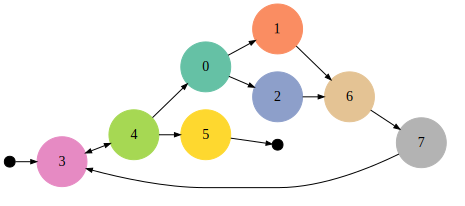

In [668]:
dot_ngrams_8 = Digraph(
    graph_attr={'rankdir': 'LR', 'margin': '0.2', 'nodesep': '0.25', 'ranksep': '0.3',
               'concentrate': 'true'},
    node_attr={'width': '0.7', 'height': '0.7', 'shape': 'circle', 'fixedsize': 'true'},
    edge_attr={'arrowsize': '0.6'}
)
ngrams_8_2_desc_by_src = desc_by_src(ngrams_8_2)
# 8-gram ids in the original order of appearance
keys = list(pd.Series(all_ngrams_8_numeric).drop_duplicates())
colors = colorize(keys)
for src, color_rgb in zip(keys, colors):
    dot_ngrams_8.node(str(src), color='%f, %f, %f' % colorsys.rgb_to_hsv(*color_rgb), style='filled')
for src, dests in ngrams_8_2_desc_by_src.iteritems():
    for dest in dests:
        if src != dest:
            dot_ngrams_8.edge(str(src), str(dest))

dot_ngrams_8.attr('node', shape='point', width='0.15')
dot_ngrams_8.node('start', '')
dot_ngrams_8.edge('start', str(all_ngrams_8_numeric[0]))
dot_ngrams_8.node('end', '')
dot_ngrams_8.edge(str(all_ngrams_8_numeric[-1]), 'end')


dot_ngrams_8.render('hladova-zed-8-gram-state-diagram.gv')
dot_ngrams_8

In [659]:
for i, name in enumerate(le_8ngram.classes_):
    print(i, ':', name)

0 : Am6 Am6 Am6 Am6 Em9 Em9 Em9 Em9
1 : Am6 Am6 Am6 Am6 H7/4 H7/4 H7 H7
2 : Am6 Am6 Am6 F#7 H7/4 H7/4 H7 H7
3 : Am7 Hm7 Em Hm7 Am7 Hm7 Em Hm7
4 : Am7 Hm7 Em Hm7 Am7 Hm7 H7 H7
5 : Em Em Em Em Em Em Em Em
6 : Em Em Hm7 Hm7 Am7 Am7 Am7 Am7
7 : H4/C H4/C Hm7 Am7 Em Em Em Em


TODO: it would be nice to rank (order) the nodes by the order of appearance in the song, instead of some (possibly random) order of the LabelEncoder.